In [1]:
# All necessary imports

import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from skimage.filters import laplace

import numpy as np
import pandas as pd
import cv2
from PIL import Image

In [2]:
# Mounting Google Drive for dataset saving and fast downloading

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Downloading dataset

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c airbus-ship-detection
"""


empty
"""

In [3]:
!unzip -q /content/drive/MyDrive/airbus-ship-detection.zip -d .

In [4]:
train_img_path = 'train_v2'
train_masks_path = 'train_ship_segmentations_v2.csv'

df_train = pd.read_csv(train_masks_path)

In [5]:
df_train.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
# @title Run-Lenght Mask Decoding

def rle_decode(mask_rle, shape=(768, 768)) -> np.array:

    # decode run-length encoded segmentation mask

    if not mask_rle or pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, mask_rle.split()))

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    starts, lengths = s[0::2], s[1::2]
    for start, length in zip(starts, lengths):
        img[start:start + length] = 1

    return img.reshape(shape).T

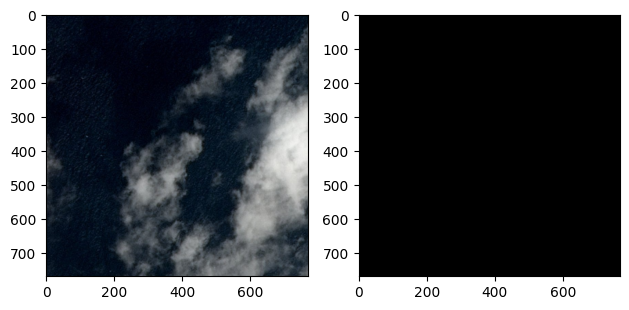

In [7]:
# @title Image, Mask review

img_path = df_train['ImageId'][20]
img = cv2.imread(os.path.join(train_img_path, img_path))

mask = rle_decode(df_train['EncodedPixels'][20])

_, ax = plt.subplots(ncols=2)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(mask, cmap='gray')
plt.tight_layout()
plt.show()

In [8]:
ship_count_by_id = df_train\
    .groupby('ImageId', as_index=False)\
    .count()\
    .rename(columns={'EncodedPixels': 'nObjects'})

ship_counts = ship_count_by_id\
    .groupby('nObjects', as_index=False)\
    .count()\
    .rename(columns={'ImageId': 'nCounts'})

In [9]:
ship_count_by_id.T


,0,1,2,3,4,5,6,7,8,9,...,192546,192547,192548,192549,192550,192551,192552,192553,192554,192555
ImageId,00003e153.jpg,0001124c7.jpg,000155de5.jpg,000194a2d.jpg,0001b1832.jpg,00021ddc3.jpg,0002756f7.jpg,0002d0f32.jpg,000303d4d.jpg,00031f145.jpg,...,fffd924fb.jpg,fffdd2377.jpg,fffe4c385.jpg,fffe4fa23.jpg,fffe646cf.jpg,fffedbb6b.jpg,ffff2aa57.jpg,ffff6e525.jpg,ffffc50b4.jpg,ffffe97f3.jpg
nObjects,0,0,1,5,0,9,2,0,0,1,...,2,1,0,0,0,0,0,0,0,0


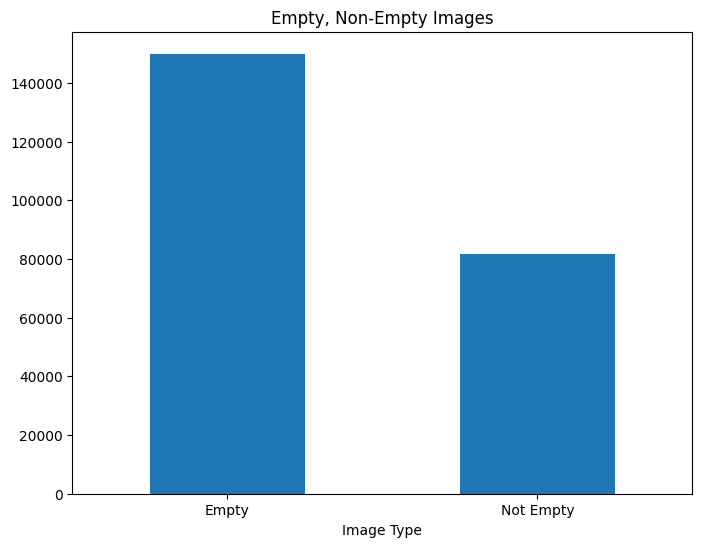

In [24]:
# @title Number of empty, non empty images

df_train['has_ship'] = df_train['EncodedPixels'].notna().astype(int)

image_counts = df_train.groupby('has_ship').size()
image_counts = image_counts.rename({0: 'Empty', 1: 'Not Empty'})

plt.figure(figsize=(8, 6))
image_counts.plot(kind='bar', rot=0)
plt.title('Empty, Non-Empty Images')
plt.xlabel('Image Type')
plt.show()

<ipython-input-10-1b0d48c7fdab>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=ship_per_image, palette="viridis")


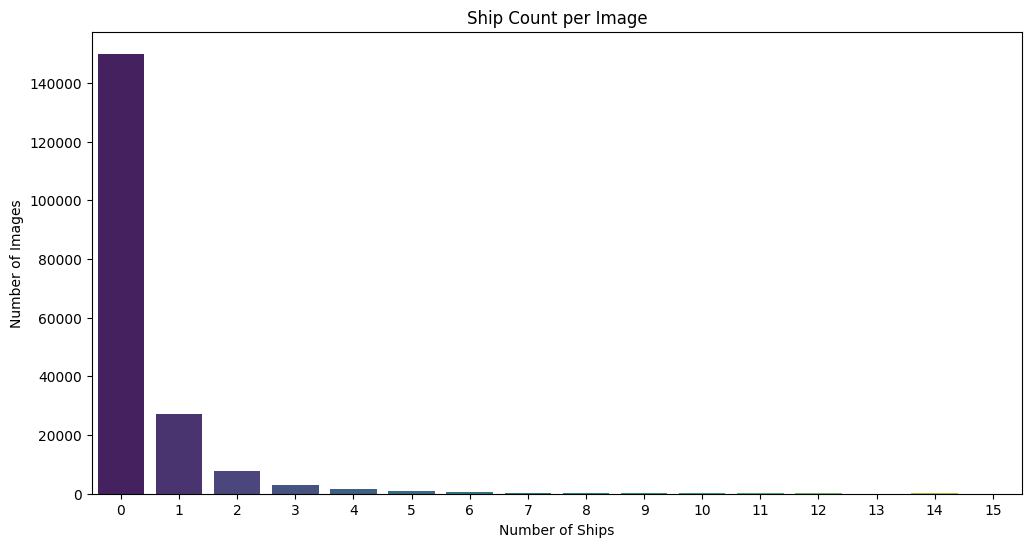

In [10]:
# @title Ship amount for image

df_train['has_ship'] = df_train['EncodedPixels'].notnull().astype(int)
ship_per_image = df_train.groupby('ImageId')['has_ship'].sum()

plt.figure(figsize=(12, 6))
sns.countplot(x=ship_per_image, palette="viridis")
plt.title('Ship Count per Image')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')
plt.show()

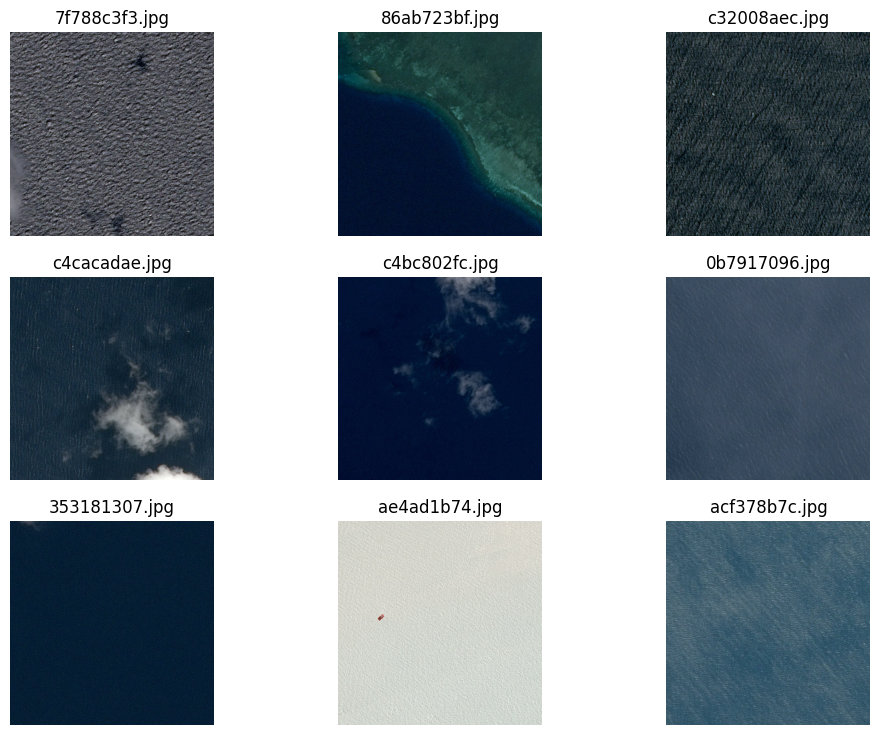

In [12]:
sample_images = df_train['ImageId'].unique()
sample_images = np.random.choice(sample_images, size=9, replace=False)

plt.figure(figsize=(12, 9))
for i, image_id in enumerate(sample_images):
    img = Image.open(os.path.join('train_v2', image_id))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(image_id)
    plt.axis('off')

    masks = df_train[df_train['ImageId'] == image_id]['EncodedPixels'].tolist()
    for mask_rle in masks:
        if isinstance(mask_rle, str):
            mask = rle_decode(mask_rle)
            plt.imshow(mask, alpha=0.5, cmap='Reds')
plt.show()

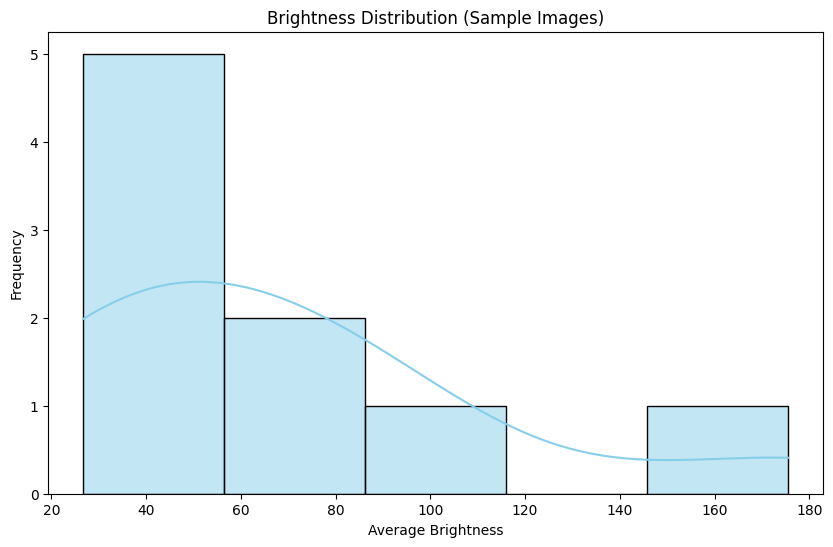

In [13]:
# @title Image brightness distribution

brightness_values = []
for image_id in sample_images:
    img = Image.open(os.path.join('train_v2', image_id))
    img_array = np.array(img)
    brightness = np.mean(img_array)
    brightness_values.append(brightness)

plt.figure(figsize=(10, 6))
sns.histplot(brightness_values, kde=True, color='skyblue')
plt.title('Brightness Distribution (Sample Images)')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency')
plt.show()

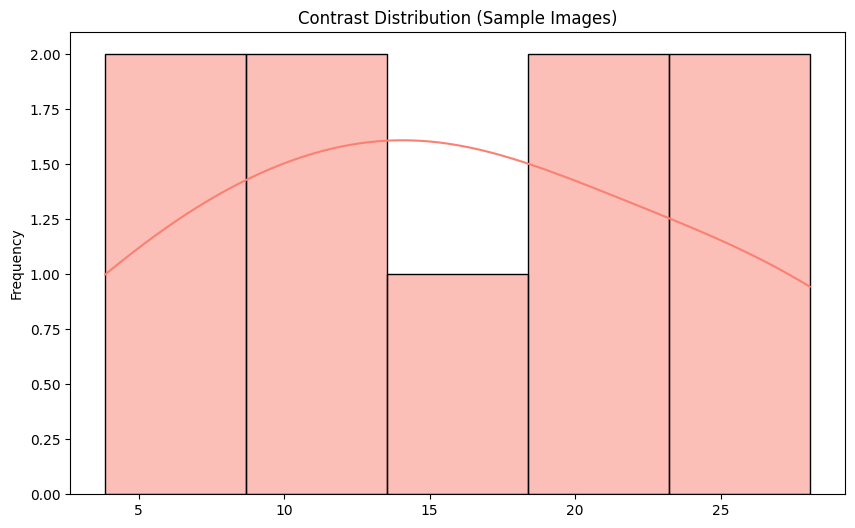

In [25]:
# @title Image contrast distribution

contrast_values = []
for image_id in sample_images:
    img = Image.open(os.path.join('train_v2', image_id)).convert('L')
    img_array = np.array(img)
    contrast = np.std(img_array)
    contrast_values.append(contrast)

plt.figure(figsize=(10, 6))
sns.histplot(contrast_values, kde=True, color='salmon')
plt.title('Contrast Distribution (Sample Images)')
plt.ylabel('Frequency')
plt.show()

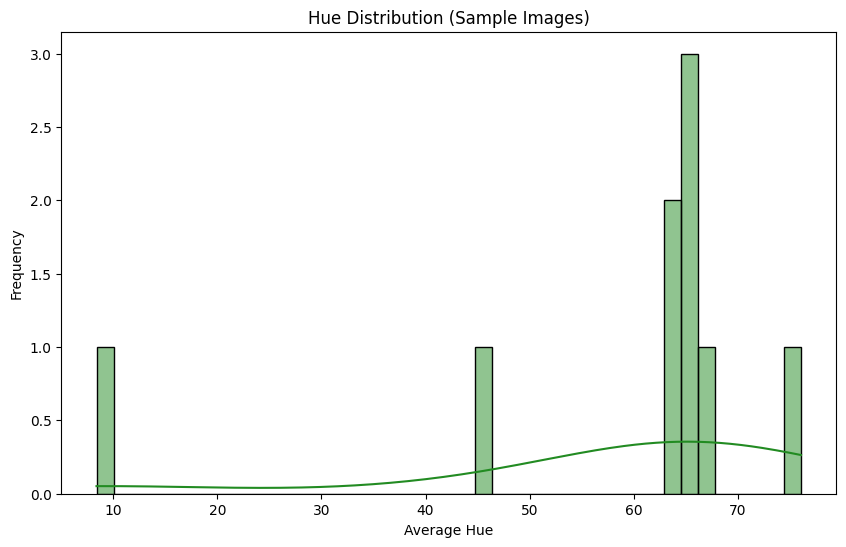

In [26]:
# @title Image hue distribution


hue_values = []
for image_id in sample_images:
    img = Image.open(os.path.join('train_v2', image_id))
    img_array = np.array(img)

    R, G, B = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]

    theta = np.arctan2(np.sqrt(3) * (G - B), 2 * R - G - B)
    hue = np.degrees(np.where(theta > 0, theta, theta + 2 * np.pi))

    average_hue = np.mean(hue)
    hue_values.append(average_hue)

plt.figure(figsize=(10, 6))
sns.histplot(hue_values, kde=True, color='forestgreen')
plt.title('Hue Distribution (Sample Images)')
plt.xlabel('Average Hue')
plt.ylabel('Frequency')
plt.show()

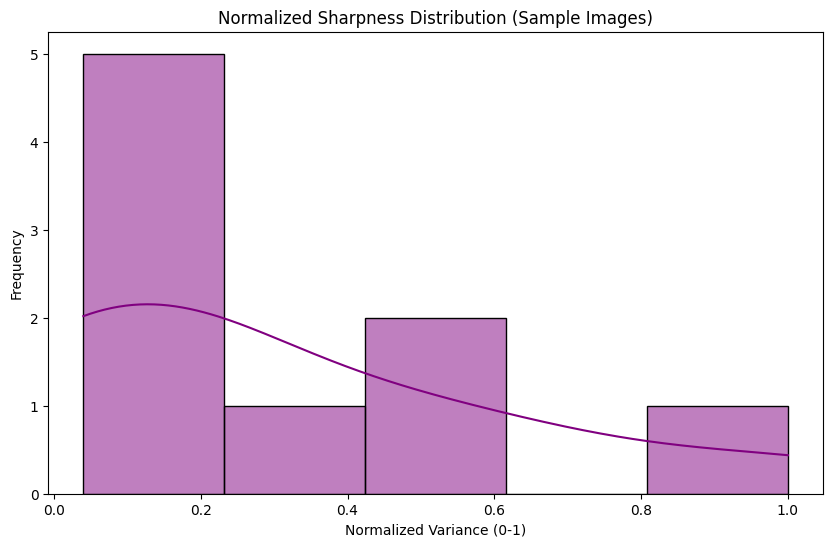

In [27]:
# @title Image sharpness(quality) distribution


sharpness_values = []
for image_id in sample_images:
    img = Image.open(os.path.join('train_v2', image_id)).convert('L')
    img_array = np.array(img)
    laplacian = laplace(img_array)
    sharpness = np.var(laplacian)
    sharpness_values.append(sharpness)

# Normalization
max_sharpness = max(sharpness_values)
normalized_sharpness_values = [s / max_sharpness for s in sharpness_values]

plt.figure(figsize=(10, 6))
sns.histplot(normalized_sharpness_values, kde=True, color='purple')
plt.title('Normalized Sharpness Distribution (Sample Images)')
plt.xlabel('Normalized Variance (0-1)')
plt.ylabel('Frequency')
plt.show()

In [17]:
# group by unique images and perform aggregation: count, sum
df_train['Area'] = df_train['EncodedPixels'].apply(lambda rle: rle_decode(rle).sum())

ship_stats_by_id = df_train\
    .groupby('ImageId', as_index=False)\
    .agg({'EncodedPixels': 'count', 'Area': 'sum'})\
    .rename(columns={'EncodedPixels': 'nObjects'})

ship_stats_by_id['avgShipArea'] = (ship_stats_by_id['Area'] / ship_stats_by_id['nObjects']).fillna(0)

ship_stats_by_id.head()

,ImageId,nObjects,Area,avgShipArea
0,00003e153.jpg,0,0,0.0
1,0001124c7.jpg,0,0,0.0
2,000155de5.jpg,1,3388,3388.0
3,000194a2d.jpg,5,1460,292.0
4,0001b1832.jpg,0,0,0.0


In [18]:
# group images by ship count,

ship_stats_by_counts = ship_stats_by_id\
    .groupby('nObjects', as_index=False)\
    .agg({'nObjects': 'count', 'Area': 'sum'})

ship_stats_by_counts['avgArea'] = (ship_stats_by_counts['Area'] / ship_stats_by_counts['nObjects'])

ship_stats_by_counts.T.astype(int)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
nObjects,150000,27104,7674,2954,1622,925,657,406,318,243,168,144,124,75,76,66
Area,0,65613868,26512649,12121034,7189721,4366249,3214644,2280847,1957149,1219387,1020741,728213,670510,371087,513120,313628
avgArea,0,2420,3454,4103,4432,4720,4892,5617,6154,5018,6075,5057,5407,4947,6751,4751


<ipython-input-28-8c12af2b2022>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ship_stats_by_counts.index, y='avgArea', data=ship_stats_by_counts, palette='Blues_d')


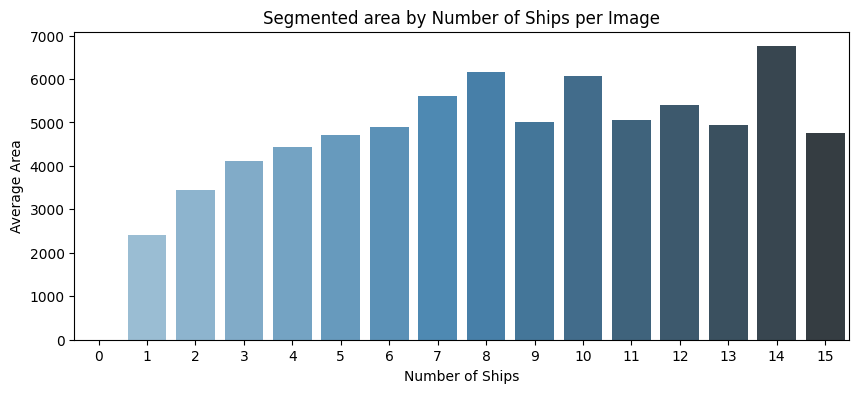

In [28]:
# @title Image mask area

plt.figure(figsize=(10, 4))
sns.barplot(x=ship_stats_by_counts.index, y='avgArea', data=ship_stats_by_counts, palette='Blues_d')
plt.xlabel('Number of Ships')
plt.ylabel('Average Area')
plt.title('Segmented area by Number of Ships per Image')
plt.show()